In [84]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold,cross_val_score
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [24]:
demographic = pd.read_csv('../data/national-health-and-nutrition-examination-survey/demographic.csv', sep=',')
diet = pd.read_csv('../data/national-health-and-nutrition-examination-survey/diet.csv', sep=',')
examination = pd.read_csv('../data/national-health-and-nutrition-examination-survey/examination.csv', sep=',')
labs = pd.read_csv('../data/national-health-and-nutrition-examination-survey/labs.csv', sep=',')
medications = pd.read_csv('../data/national-health-and-nutrition-examination-survey/medications.csv', sep=',', encoding='iso-8859-1')
questionnaire = pd.read_csv('../data/national-health-and-nutrition-examination-survey/questionnaire.csv', sep=',')

In [25]:
medications = medications[medications.RXDRSD1.notnull()]

In [26]:
df = pd.merge(demographic, examination, how='outer', on='SEQN')
# df
df = pd.merge(df, diet, how='outer', on='SEQN')
# df
df = pd.merge(df, labs, how='outer', on='SEQN')
# df
df = pd.merge(df, medications, how='outer', on='SEQN')
# df
df = pd.merge(df, questionnaire, how='outer', on='SEQN')
# df

In [27]:
#Se eliminan las filas y columnas que tengan todos los elementos nulos
df=df.dropna(axis=0,how='all')
df=df.dropna(axis=1,how='all')

In [6]:
#IMPUTACION NAN

In [28]:
#Imputamos RIDAGEMN. Esta variable es la edad en meses y en pacientes mayores de 2 años no aparece este dato. Es una variable
#interesante de mantener para poder tener una edad más exacta.
#Así que en los registros que no existan, multiplicamos la edad en años, RIDAGEYR, por 12 para obtener los meses.
# df.RIDAGEYR*12

df.RIDAGEMN=df.RIDAGEMN.replace(np.nan, df.RIDAGEYR*12)

In [29]:
#Imputamos RIDEXAGM. Esta variable es la edad en meses en el momento del examen. Si el valor es nulo, 
# lo imputamos con el valor de RIDAGEMN

df.RIDEXAGM=df.RIDEXAGM.replace(np.nan, df.RIDAGEMN)

In [30]:
#Imputación de nan
for column in df.columns:
    if df[column].isnull().sum() != 0:
        if df[column].dtype==object:
            df[column].fillna(value=df[column].value_counts().index[0],inplace =True)
        else:
            df[column].fillna(df[column].median(),inplace =True)

In [31]:
#CREAMOS VARIABLE IMC, la altura está en cm
df.BMI=df.BMXWT*100/df.BMXHT.astype(np.float64)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [32]:
# CORRELACION
matrizCorrelacion=df.corr()

In [33]:
variablesRelacionadas = list()
for i in range(len(matrizCorrelacion)):
    var1 = matrizCorrelacion.columns[i]
    for j in range(len(matrizCorrelacion)):
        var2 = matrizCorrelacion.columns[j]
        elemento = matrizCorrelacion.iloc[i,j]
        if (i<j) & (abs(elemento)==1):
            a = list()
            a.append([var1, var2])
            a.append(elemento)
            variablesRelacionadas.append(a)
variablesRelacionadas

[[['URXUMA', 'URXUMS'], 1.0],
 [['WTSAF2YR.x', 'WTSAF2YR.y'], 1.0],
 [['WTSAF2YR.x', 'WTSAF2YR'], 1.0],
 [['LBXSCA', 'LBDSCASI'], 1.0],
 [['WTSA2YR.x', 'WTSA2YR.y'], 1.0],
 [['WTSA2YR.x', 'WTSA2YR'], 1.0],
 [['WTSB2YR.x', 'WTSB2YR'], 1.0],
 [['ORXGH', 'ORXGL'], 1.0],
 [['ORXGH', 'ORXH64'], 1.0],
 [['ORXGL', 'ORXH64'], 1.0],
 [['WTSAF2YR.y', 'WTSAF2YR'], 1.0],
 [['WTSH2YR.x', 'WTSH2YR.y'], 1.0],
 [['WTSA2YR.y', 'WTSA2YR'], 1.0],
 [['SMAQUEX2', 'SMAQUEX.y'], -1.0]]

In [34]:
#Eliminamos las variables correladas
for i in variablesRelacionadas:
    if i[0][1] in df.columns:
        df.drop([i[0][1]], axis = 1, inplace=True)

In [35]:
columnasNumericas=df._get_numeric_data().columns

In [36]:
df=pd.get_dummies(df)

In [37]:
#NORMALIZAMOS CON StandardScaler
scaler = StandardScaler()
df[columnasNumericas]=scaler.fit_transform(df[columnasNumericas])

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [38]:
#definimos a los pacientes que no sean hipertensivos como 0 y los que si lo son como 1
# hipertension ==>  RXDRSC1 = I10

df.rename(columns={'RXDRSC1_I10':'is_hypertensive'}, inplace=True)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, df.columns != 'is_hypertensive'],df['is_hypertensive'], 
                                                    test_size=1/3, random_state=158)

In [ ]:
#SVC

In [40]:
SVCclf = SVC()
SVCclf.fit(X_train, y_train)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [80]:
prediccionSVC = SVCclf.predict(X_test)
precisionSVC = (np.sum(prediccionSVC == y_test)/len(prediccionSVC))*100
print('La precisión para SVC es {}'.format(precisionSVC))

La precisión para SVC es 91.73992118823887


In [82]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [90]:
def matrizConfusion(Ytest, prediccion):
    matrizConf = confusion_matrix(Ytest, prediccion)
    fig, ax = plot_confusion_matrix(conf_mat=matrizConf)
plt.show()

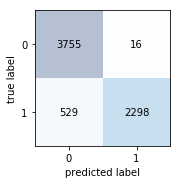

In [91]:
matrizConfusion(y_test, prediccionSVC)

In [38]:
##GradientBoostingClassifier

In [43]:
gbc = GradientBoostingClassifier()

gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [79]:
prediccionGBC = gbc.predict(X_test)
precisionGBC = (np.sum(prediccionGBC == y_test)/len(prediccionGBC))*100
print('La precisión para GradientBoosting es {}'.format(precisionGBC))

La precisión para GradientBoosting es 100.0


In [45]:
scores = cross_val_score(gbc, X_train, y_train, cv=5)

In [46]:
print('Precision promedio: {0: .3f} +/- {1: .3f}'.format(np.mean(scores),
                                          np.std(scores)))

Precision promedio:  1.000 +/-  0.000


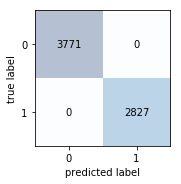

In [92]:
matrizConfusion(y_test, prediccionGBC)

In [ ]:
# AdaBoost

In [47]:
ABC = AdaBoostClassifier()
ABC.fit(X_train, y_train) 

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [48]:
prediccionABC=ABC.predict(X_test)

In [78]:
precisionABC = (np.sum(prediccionABC == y_test)/len(prediccionABC))*100
print('La precisión para AdaBoost es {}'.format(precisionABC))

La precisión para AdaBoost es 100.0


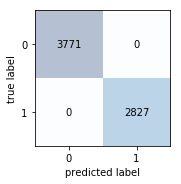

In [93]:
matrizConfusion(y_test, prediccionABC)

In [77]:
# Random Forest

In [51]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
prediccionRFC=RFC.predict(X_test)

In [76]:
precisionRFC = (np.sum(prediccionRFC == y_test)/len(prediccionRFC))*100
print('La precisión para Random Forest es {}'.format(precisionRFC))

La precisión para Random Forest es 92.13397999393756


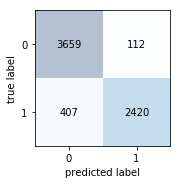

In [94]:
matrizConfusion(y_test, prediccionRFC)

In [ ]:
#Bayesiano

In [55]:
bayes = GaussianNB()
bayes.fit(X_train, y_train) 

GaussianNB(priors=None, var_smoothing=1e-09)

In [56]:
prediccionBayes=bayes.predict(X_test)

In [75]:
precisionBayes = (np.sum(prediccionBayes == y_test)/len(prediccionBayes))*100
print('La precisión para Bayesiano es {}'.format(precisionBayes))

La precisión para Bayesiano es 99.43922400727493


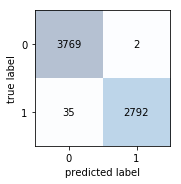

In [95]:
matrizConfusion(y_test, prediccionBayes)

In [74]:
#Logistic Regression

In [59]:
LG = linear_model.LogisticRegression()
LG.fit(X_train,y_train)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [60]:
prediccionLG = LG.predict(X_test)

In [73]:
precisionLG = (np.sum(prediccionLG == y_test)/len(prediccionLG))*100
print('La precisión para Logistic Regression es {}'.format(precisionLG))

La precisión para Logistic Regression es 99.98484389208852


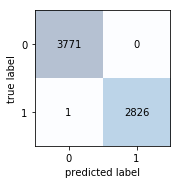

In [96]:
matrizConfusion(y_test, prediccionLG)

In [64]:
#KNN

In [66]:
knn = KNeighborsClassifier(n_neighbors=k, weights=peso)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [67]:
prediccionKNN = knn.predict(X_test)

In [72]:
precisionKNN = (np.sum(prediccionKNN == y_test)/len(prediccionKNN))*100
print('La precisión para k-NN es {}'.format(precisionKNN))

La precisión para k-NN es 70.56683843588966


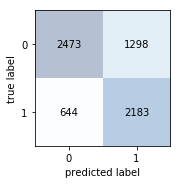

In [97]:
matrizConfusion(y_test, prediccionKNN)